# Import Modules

In [0]:
import matplotlib.pyplot as plt
# from PIL import Image
import cv2
import pandas as pd
import numpy as np
import os
from numpy import asarray
from tqdm import tqdm
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization, Reshape, MaxPooling2D, CuDNNLSTM, Embedding
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, hamming_loss, zero_one_loss

# from keras.preprocessing.image import ImageDataGenerator
# from keras.models import Sequential
# from keras.layers import Conv2D
# from keras.layers import MaxPooling2D
# from keras.layers import Dense
# from keras.layers import Flatten

Using TensorFlow backend.


# Data Preparation

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Please use your own google drive path, you may load the google drive to the colab first
# The path should be "/your path/semeval-2020_trialdata"
cd "/content/drive/My Drive/SemEval_2020/semeval-2020_trialdata" # trial dataset


[Errno 2] No such file or directory: '/content/drive/My Drive/SemEval_2020/semeval-2020_trialdata # trial dataset'
/content


In [0]:
pwd #current path

'/content'

## Read CSV Data

In [0]:
PATH_CSV = "data1.csv"
PATH_IMG = "./Meme_images/"
trainX=[]
data = pd.read_csv(PATH_CSV)  
# data.columns = ['Image_name', 'Image_URL', 'OCR_extracted_text', 'corrected_text',
#        'Humour', 'Sarcasm', 'offensive', 'Motivational', 'Overall_Sentiment']
data.shape

(914, 10)

In [0]:
data.head(3)

,Image_name,Image_URL,OCR_extracted_text,corrected_text,Humour,Sarcasm,offensive,Motivational,Overall_Sentiment,Basis_of_classification
0,skeptical_stealing-my-milk.jpg,http://www.relatably.com/m/img/funny-skeptical...,ISAW DAD WITH MOM LASTNIGHT I THINK HE WAS STE...,,very_funny,general,hateful_offensive,not_motivational,very_positive,image_and_text
1,skeptical_breathing+if+she+has+my+nose.jpg,http://1.bp.blogspot.com/-g0E1yGCghCI/T68yJ1Oj...,HOW AM I STILL BREATHING IF SHE HAS MY NOSE? q...,HOW AM I STILL BREATHING IF SHE HAS MY NOSE? q...,funny,general,not_offensive,motivational,negative,image
2,skeptical_603b3553d88441537f6c65abac8a1cec.jpg,https://i.pinimg.com/736x/60/3b/35/603b3553d88...,YOU MEAN TO TELL ME BIGG BOSSIS BETTER THAN KB...,,not_funny,not_sarcastic,not_offensive,not_motivational,neutral,image_and_text


In [0]:
data['Overall_Sentiment'].value_counts()

positive           407
neutral            277
very_positive      149
negative            50
very_negative       20
image_and_text       8
text                 2
image                1
Name: Overall_Sentiment, dtype: int64

In [0]:
#delete wrong data
data = data[data['Overall_Sentiment'].isin(['positive','neutral','very_positive','negative','very_negative'])]
data['Overall_Sentiment'].value_counts()

positive         407
neutral          277
very_positive    149
negative          50
very_negative     20
Name: Overall_Sentiment, dtype: int64

## Read Image data

In [0]:
# #use pillow, use the same data for missing channels in error image

# size = 73, 50
# X = [ ]     # creating an empty array
# error = []
# for img_name in tqdm(data['Image_name']):
#   if(os.path.isfile(PATH_IMG + img_name)):
#     image = Image.open(PATH_IMG + img_name)
#     img = asarray(image.resize(size))
#     if img.ndim != 3:
#       img = np.dstack([img, img, img])
#       error.append(img_name)
#     X.append(img)  # storing each image in array X
#   else:
#     error.append(img_name)
# X = np.array(X)    # converting list to array
# print(error)

In [0]:
## or use cv2, and delete 2-channel error image
c = 0
size = 128,128  # img size: height, width 
X = [ ]     # creating an empty array
error = []
for img_name in tqdm(data['Image_name']):
  c += 1
#   image = Image.open(PATH_IMG + img_name)
#   img = asarray(image.resize(size))
  if(os.path.isfile(PATH_IMG + img_name)):
    image = cv2.imread((PATH_IMG + img_name), cv2.IMREAD_COLOR)
    if image is not None:
#       pass
      img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, size)
      if img.ndim != 3:                  # if the image is not RGB
        img = np.dstack([img, img, img]) # use the same value for the 3 RGB channels
      X.append(img)  # storing each image in array X
    else:
      print('None:{}'.format(img_name))
      error.append(img_name)
  else:
    print('Not Exists:{}'.format(img_name))
    error.append(img_name)
  # print(c,img.shape, img_name)
print(error)

X = np.array(X)   # converting list to array
width, height, channels = X.shape[1:]


100%|██████████| 903/903 [04:15<00:00,  2.19it/s]

[]


In [0]:
data = data[~data['Image_name'].isin(error)] # exclude error loaded images data

Y = data['Overall_Sentiment']

5-class to 3-class

In [0]:
Y = Y.replace('very_positive','positive').replace('very_negative','negative')
Y.value_counts()

# transform Y to one-hot vector
num_class = 3
Y = to_categorical(Y.factorize()[0])

 *Or Import processed data* (ignore this)

In [0]:
# Import pre-processed image data
# import pickle

# data = pickle.load(open("/content/drive/My Drive/SemEval_2020/pickles/data_processed.pickle", "rb"))
# error = pickle.load(open("/content/drive/My Drive/SemEval_2020/pickles/error_26img_name.pickle", "rb"))
# X = pickle.load(open("/content/drive/My Drive/SemEval_2020/pickles/X_6574_73-50.pickle", "rb"))
# Y = pickle.load(open("/content/drive/My Drive/SemEval_2020/pickles/Y_6574.pickle", "rb"))
# width, height, channels = X.shape[1:]

In [0]:
data.shape,len(error),X.shape,Y.shape

((903, 10), 0, (903, 128, 128, 3), (903, 3))

# Modelling

## Text Data + LSTM

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [0]:
t = Tokenizer()
X_text = data['Image_name']+data['OCR_extracted_text']+data['corrected_text']
X_text = [str(i).replace('_',' ').replace('-',' ').replace('.jpg',' ').replace('.png',' ') for i in X_text]
t.fit_on_texts(X_text)
vocab_size = len(t.word_index) + 1
print (vocab_size)

4845


In [0]:
data['OCR_extracted_text']

0      ISAW DAD WITH MOM LASTNIGHT I THINK HE WAS STE...
1      HOW AM I STILL BREATHING IF SHE HAS MY NOSE? q...
2      YOU MEAN TO TELL ME BIGG BOSSIS BETTER THAN KB...
3      MY SHARE OF THE NATIONAL DEBT IS HOW MUCHP qui...
4      WAIT A SECOND BILLA AM I SKEPTICAL BABY GROWN ...
                             ...                        
909                             I love you lamp Shut up 
910    I GOT YOU A PRESENT FOR YOUR BIRTHDAY IT'S IN ...
911         WHAT IF THE HUMAN IS NOT MY PET BUT I'M HIS 
912    WOW! NEW SOFA I'LL SHOW NO MERCY CatBreed Sele...
913             HUMAN YOUR TAIL IS ON BACKWARDS zipmeme 
Name: OCR_extracted_text, Length: 903, dtype: object

In [0]:
encoded_train = t.texts_to_sequences(X_text)
max_length = max(list(map(lambda x: len(x), encoded_train)))
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')

padded_train[1]

array([  34,  503,   57,  193,   81,   20,  298,   54,  100,    4,  116,
        503,   57,  193,   81,   20,  298, 2000,    7,   54,  100,    4,
        116,  503,   57,  193,   81,   20,  298,   52,    7,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [0]:
padded_train.shape, Y.shape

((903, 184), (903, 3))

Split data into 80% training set and 20% test set using stratified sampling

In [0]:
# Train-test Split
np.random.RandomState(0)
trainX, testX, trainY, testY = train_test_split(padded_train, Y, test_size=0.1, random_state=0,stratify=Y)
# summarize dataset shape
print('Train', trainX.shape, trainY.shape)
print('Test', (testX.shape, testY.shape))

# summarize pixel values
print('Train', trainX.min(), trainX.max(), trainX.mean(), trainX.std())
print('Test', testX.min(), testX.max(), testX.mean(), testX.std())

Train (812, 184) (812, 3)
Test ((91, 184), (91, 3))
Train 0 4844 94.16905386592418 487.62347934543345
Test 0 4841 98.617773530817 515.8899300785372


In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Dropout(0.3))


model.add(CuDNNLSTM(128))
model.add(Dropout(0.2))
# model.add(Flatten())
model.add(Dense(32, activation='relu'))

model.add(Dense(num_class, activation='softmax'))

# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 184, 100)          484500    
_________________________________________________________________
dropout (Dropout)            (None, 184, 100)          0         
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 128)               117760    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_______________________________________________________

In [0]:
from keras import callbacks
es = callbacks.EarlyStopping(monitor='val_acc', mode='max')
results = model.fit(trainX, trainY, epochs=5, shuffle=True, validation_data=(testX,testY), batch_size=64,callbacks=[es])

Train on 812 samples, validate on 91 samples
Epoch 1/50
812/812 [==============================] - 14s 17ms/sample - loss: 0.9592 - acc: 0.5998 - val_loss: 0.8631 - val_acc: 0.6154
Epoch 2/50
812/812 [==============================] - 0s 340us/sample - loss: 0.8825 - acc: 0.6158 - val_loss: 0.8593 - val_acc: 0.6154


In [0]:
model.evaluate(testX,testY)

91/91 [==============================] - 2s 24ms/sample - loss: 0.8593 - acc: 0.6154


[0.8592978755196372, 0.61538464]

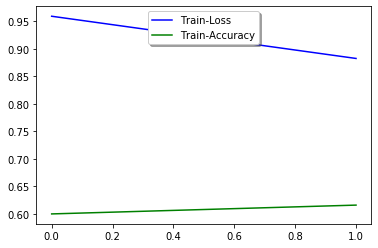

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

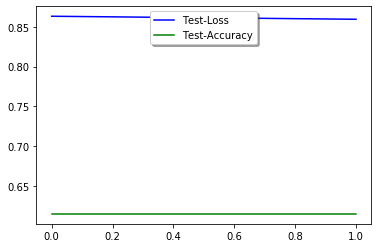

In [0]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

## Image Data + CNN

In [0]:
# Train-test Split
np.random.RandomState(0)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=0,stratify=Y)

# summarize dataset shape
print('Train', trainX.shape, trainY.shape)
print('Test', (testX.shape, testY.shape))

# summarize pixel values
print('Train', trainX.min(), trainX.max(), trainX.mean(), trainX.std())
print('Test', testX.min(), testX.max(), testX.mean(), testX.std())

Train (722, 128, 128, 3) (722, 3)
Test ((181, 128, 128, 3), (181, 3))
Train 0 255 120.32734709763461 86.52757778037356
Test 0 255 128.07709201089145 86.95159013612833


In [0]:
# reshape dataset to have a single channel
# width, height, channels = trainX.shape[1], trainX.shape[2], trainX.shape[3]
# trainX = trainX.reshape((trainX.shape[0], width,height,channels))
# testX = testX.reshape((testX.shape[0], width,height,channels))

# one hot encode target values
# trainY = to_categorical(trainY.factorize()[0])
# testY = to_categorical(testY.factorize()[0])

# create generator (1.0/255.0 = 0.003921568627451)
# datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True) # standardize

# prepare an iterators to scale images
# train_iterator = datagen.flow(trainX, trainY, batch_size=64)
# test_iterator = datagen.flow(testX, testY, batch_size=64)
# print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))

# confirm the scaling works
# batchX, batchy = train_iterator.next()
# print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

In [0]:
# define model
model = Sequential()
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))

model.add(Dense(num_class, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 30, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)           

In [0]:
from keras import callbacks
es = callbacks.EarlyStopping(monitor='val_acc', mode='max')
# fit model with generator
results = model.fit(trainX, trainY,
         epochs=50,
         batch_size=256,
         shuffle=True,
#         validation_split=0.2
         validation_data=(testX,testY),
         callbacks = [es]
         )
# model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator), epochs=1)

# evaluate model
# _, acc = model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)
# print('Test Accuracy: %.3f' % (acc * 100))

Train on 722 samples, validate on 181 samples
Epoch 1/50
722/722 [==============================] - 8s 11ms/sample - loss: 2653.1021 - acc: 0.3560 - val_loss: 483.4078 - val_acc: 0.6133
Epoch 2/50
722/722 [==============================] - 1s 2ms/sample - loss: 697.1282 - acc: 0.6163 - val_loss: 11.8368 - val_acc: 0.6133


In [0]:
model.evaluate(testX,testY)

181/181 [==============================] - 1s 3ms/sample - loss: 11.8368 - acc: 0.6133


[11.836774262275485, 0.6132597]

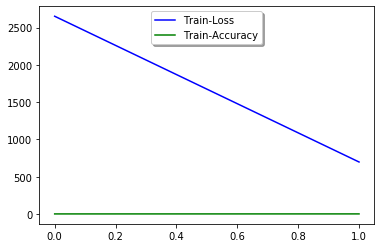

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

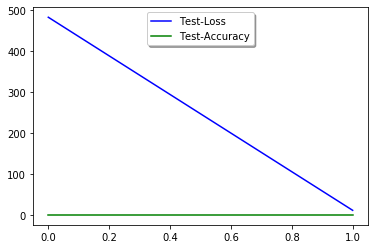

In [0]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

# Manual Test

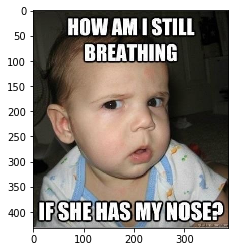

In [0]:
test_img = cv2.cvtColor(cv2.imread(PATH_IMG+data['Image_name'][1]), cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

In [0]:
data[:5]

,Image_name,OCR_extracted_text,Overall_Sentiment
0,10_year_10-year-challenge_1547788782.jpeg,The best of #10 YearChallenge! Completed in le...,very_positive
1,10_year_10yearchallenge-5c75f8b946e0fb0001edc7...,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
2,10_year_10-year-challenge-sweet-dee-edition-40...,10 Year Challenge - Sweet Dee Edition,positive
3,10_year_10-year-challenge-with-no-filter-47-hi...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral
4,10_year_10-years-challenge-about-humanity_o_72...,"1998: ""Don't get in car with strangers"" 2008: ...",negative


In [0]:
#prediction
temp = model.predict(X[800:813].reshape(-1,50,73,3))
temp_pre = [np.argmax(i) for i in temp]
temp_pre

[3, 2, 1, 1, 2, 1, 2, 2, 3, 2, 0, 1, 2]

In [0]:
#Ground Truth
temp = Y[800:813]
temp_truth = [np.argmax(i) for i in temp]
temp_truth

[2, 0, 2, 4, 2, 1, 0, 1, 3, 4, 0, 1, 1]

In [0]:
accuracy_score(temp_pre, temp_truth)

0.38461538461538464

In [0]:
model.evaluate(X[800:813],Y[800:813])

13/13 [==============================] - 0s 573us/sample - loss: 1.4527 - acc: 0.7538


[1.4527454376220703, 0.75384617]

In [0]:
12/13

0.9230769230769231